# Data collection

In [1]:
# imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import matplotlib
import matplotlib as mpl
from scipy.interpolate import make_interp_spline

In [2]:
# configurations

plt.rcParams['figure.figsize'] = [10, 5]
dir_list = os.listdir()
count_people_in_our_study = 0
for file in dir_list:
    x = re.search("^[a-zA-Z0-9]*_A.csv$", file)
    if x:
        count_people_in_our_study += 1

In [3]:
dfs = {}

for suffix in ["A", "B"]:
    first = True
    new_csv = None
    count = 0
    df = pd.DataFrame()
    for file in dir_list:
        keep_same = {'test_nb'}
        x = re.search("^[a-zA-Z0-9]*_" + suffix + ".csv$", file)
        if x:
            new_csv = pd.read_csv(file)
            if count == count_people_in_our_study - 1:
                keep_same = {'test_nb', 'W', 'D', 'Fitts'}
            else:
                new_csv = new_csv.drop(columns=['W', 'D', 'Fitts'])
                keep_same = {'test_nb'}
            temp_str = "_" + file.split("_")[0]
            new_csv.columns = ['{}{}'.format(c, '' if c in keep_same else temp_str ) for c in new_csv.columns]
            if first:
                df = new_csv
                first = False
            else:
                df = pd.merge(df, new_csv, on="test_nb", suffixes = (None, temp_str))
            count += 1
    dfs[suffix] = df

In [4]:
# i need to put the methods in an array
tests_info = pd.read_csv("tests_info.csv")
dfs["A"] = pd.merge(dfs["A"], tests_info)
dfs["B"] = pd.merge(dfs["B"], tests_info)

# 1- Which tests by mouse vs. direct touch (- heatmap : color code the performance, green is the trackpad & red for direct touch) ✅

In [5]:
# here we're doing heatmaps and we only need the A data
heatmap_array = np.empty((27,4),dtype=object)
for i,j in dfs["A"].iterrows():
    # for one test
    mouse = 0
    direct = 0
    for data in j:
        if data == "Mouse":
            mouse += 1
        elif data == "Direct touch":
            direct += 1
    heatmap_array[int(j.test_nb) - 1] = [direct, mouse, j.size_target, j.position]

heatmap_data = pd.DataFrame(heatmap_array)
heatmap_data.columns = ['direct', 'mouse', 'size_target', 'position']

In [6]:
heatmap_data = heatmap_data.groupby('position').agg({
    'direct': lambda x: list(x),
    'mouse': lambda x: list(x),
    'size_target': lambda x: list(x),
})

In [7]:
S = []
M = []
L = []
global_max = 0
for i in heatmap_data.mouse:
    S.append(i[0])
    M.append(i[1])
    L.append(i[2])
    my_local_max = np.maximum.reduce([S,M,L]).max()
    if my_local_max > global_max:
        global_max = my_local_max

In [8]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, ticks=range(global_max + 1))
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

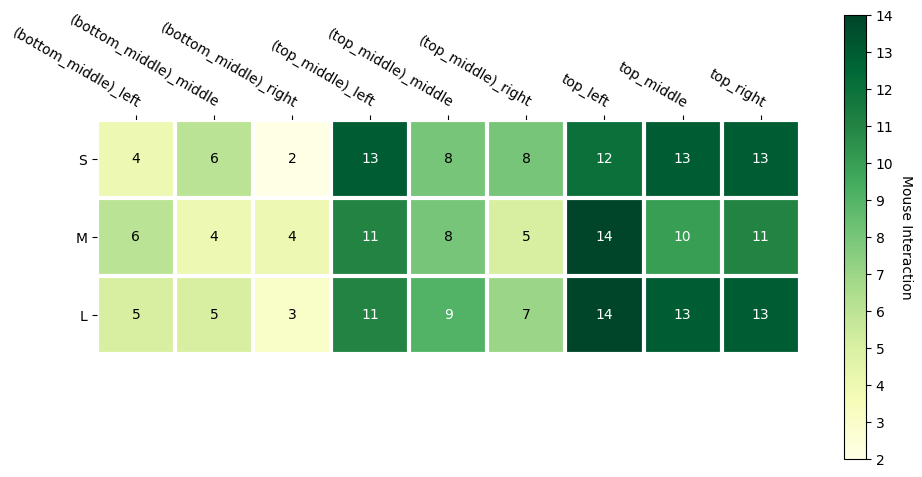

In [9]:
vegetables = ["S", "M", "L"]
farmers = heatmap_data.index
harvest = np.array([S,
                    M,
                    L])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="Mouse Interaction")
texts = annotate_heatmap(im, valfmt="{x}")

fig.tight_layout()
plt.show()

<p style="color:red">we notice 4 position where the users used the mouse interaction the most, these positions are:</p>
<ul style="color:red">
    <li>top left</li>
    <li>top right</li>
    <li>top middle</li>
    <li>top middle left</li>
</ul>
<p style="color:red">
This can be easily deduced because these positions are the furthest and hardest to reach by finger. <br/>
Another observation is the the bottom middle right position has the least mouse interaction. This is because it's very close to the hand of the user as well as it is very. hard to reach by the mouse (the target is usually covered by the user's hand).
</p>

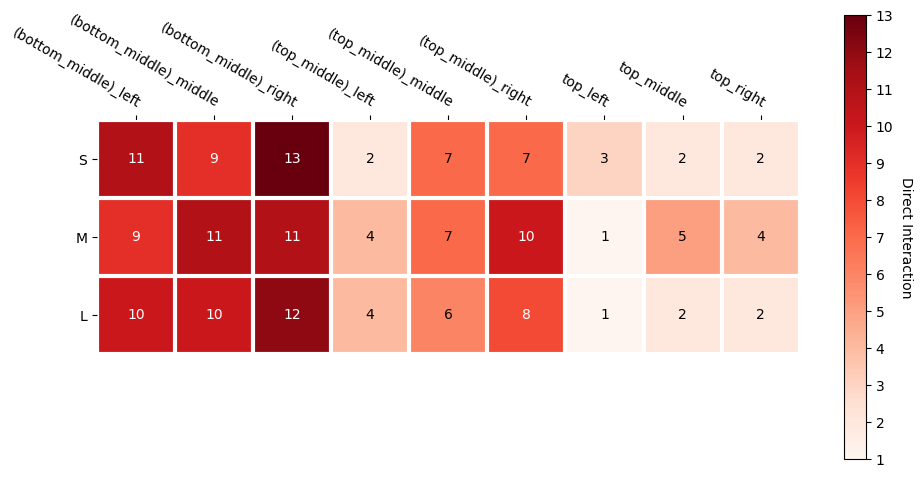

In [10]:
S = []
M = []
L = []
global_max = 0
for i in heatmap_data.direct:
    S.append(i[0])
    M.append(i[1])
    L.append(i[2])
    my_local_max = np.maximum.reduce([S,M,L]).max()
    if my_local_max > global_max:
        global_max = my_local_max


vegetables = ["S", "M", "L"]
farmers = heatmap_data.index
harvest = np.array([S,
                    M,
                    L])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="Reds", cbarlabel="Direct Interaction")
texts = annotate_heatmap(im, valfmt="{x}")

fig.tight_layout()
plt.show()

# 2- Model our data on Fitt's law ✅ 

In [11]:
fitts_df_A = dfs["A"].filter(regex= ("^time_[a-zA-Z0-9]*|test_nb|Fitts|D$"))
fitts_df_B = dfs["B"].filter(regex= ("^time_[a-zA-Z0-9]*|test_nb|Fitts|D$"))

averages_of_time_A = pd.DataFrame(fitts_df_A.iloc[:,1:-1].mean(axis=1))
averages_of_time_B = pd.DataFrame(fitts_df_B.iloc[:,1:-1].mean(axis=1))

In [12]:
averages_of_time_A.columns = ["averages_of_time_A"]
averages_of_time_B.columns = ["averages_of_time_B"]


my_fitts_plotting_data = pd.concat((averages_of_time_A, averages_of_time_B, fitts_df_A), axis=1).filter(["test_nb","averages_of_time_A", "averages_of_time_B" , "Fitts", "D"])

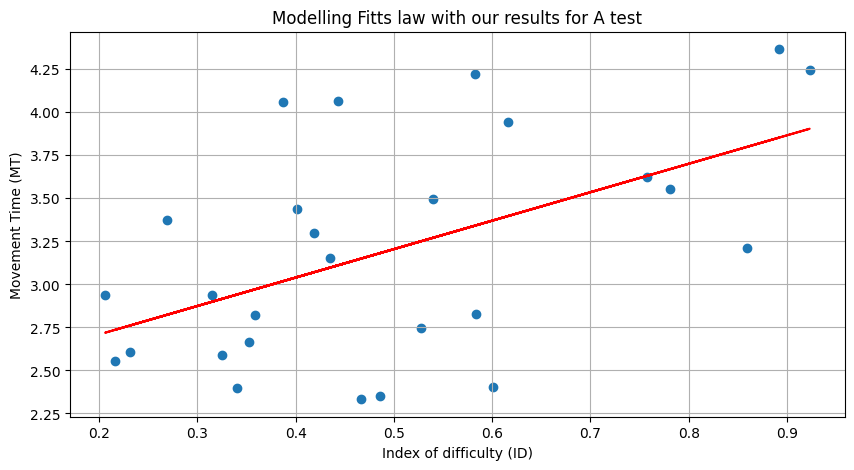

In [13]:
def model(x, a0=3, a1=2, a2=0):
    return a0 + (a1*x) + (a2*x*x)

x = my_fitts_plotting_data.Fitts
y = my_fitts_plotting_data.averages_of_time_A

plt.scatter(x, y)
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='r')
plt.grid(True)
plt.title('Modelling Fitts law with our results for A test')
plt.xlabel('Index of difficulty (ID)')
plt.ylabel('Movement Time (MT)');

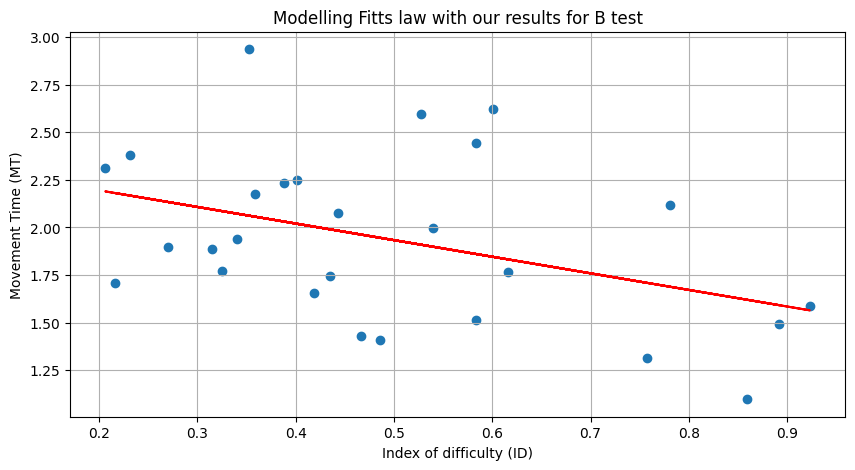

In [14]:
def model(x, a0=3, a1=2, a2=0):
    return a0 + (a1*x) + (a2*x*x)

x = my_fitts_plotting_data.Fitts
y = my_fitts_plotting_data.averages_of_time_B

plt.scatter(x, y)
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='r')
plt.grid(True)
plt.title('Modelling Fitts law with our results for B test')
plt.xlabel('Index of difficulty (ID)')
plt.ylabel('Movement Time (MT)');

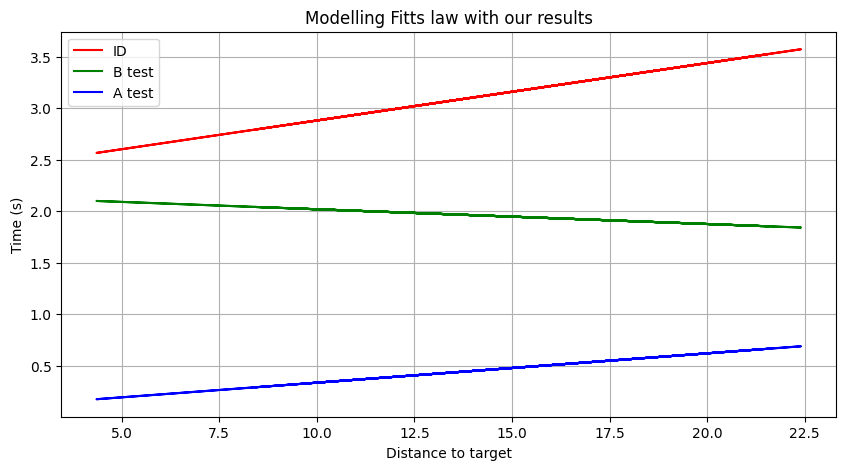

In [15]:
def model(x, a0=3, a1=2, a2=0):
    return a0 + (a1*x) + (a2*x*x)


x = my_fitts_plotting_data.D
y = my_fitts_plotting_data.averages_of_time_A

# plt.scatter(x, y)
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='r', label='ID')

x = my_fitts_plotting_data.D
y = my_fitts_plotting_data.averages_of_time_B

# plt.scatter(x, y)
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='g', label='B test')

x = my_fitts_plotting_data.D
y = my_fitts_plotting_data.Fitts

plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='b', label='A test')

x = None
plt.grid(True)
plt.legend()
plt.title('Modelling Fitts law with our results')
plt.xlabel('Distance to target')
plt.ylabel('Time (s)');

# 3- Histogram for small medium large

### A) Time taken with respect to target sizes for A test

In [16]:
sml_hist_df_A = dfs["A"].filter(regex= ("^time_[a-zA-Z0-9]*|test_nb|position|size_target$"))

sml_hist_plotting_data = pd.concat((averages_of_time_A, averages_of_time_B, sml_hist_df_A), axis=1).filter(["test_nb","averages_of_time_A", "averages_of_time_B" , "position", "size_target"])

# sml_hist_plotting_data = sml_hist_plotting_data.sort_values(by="test_nb")

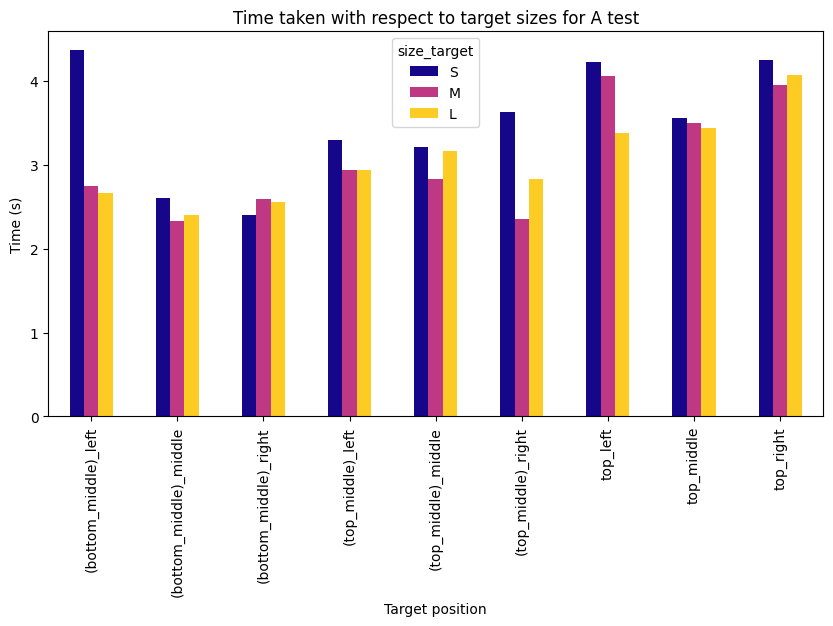

In [17]:
x = sml_hist_plotting_data.pivot_table('averages_of_time_A', ['position'], 'size_target')
x = x.reset_index(level=0)
ax = x.plot(x="position", y=["S", "M", "L"], kind="bar", rot=90, color = ['#15068a', '#be3883', '#fccc25'], title="Time taken with respect to target sizes for A test", xlabel = "Target position", ylabel = "Time (s)")


### TODO: Model error (mean) on seaborn

<p style="color:red">
In this analysis, we notice that regardless of the position of the test, it's clear that Small targets take the most time to be reached. <br/>
What also stands out here, is the bottom_middle left target of size Small. This target is taking the highest amounnt of time to reach. According to our observations, users were almost always trying to reach this target using the mouse, and then they switch to finger. This is coherent with the above histogram where we can see that this target has 11 out of 13 direct touch interactions.
</p>

### B) Time taken with respect to target sizes for B test

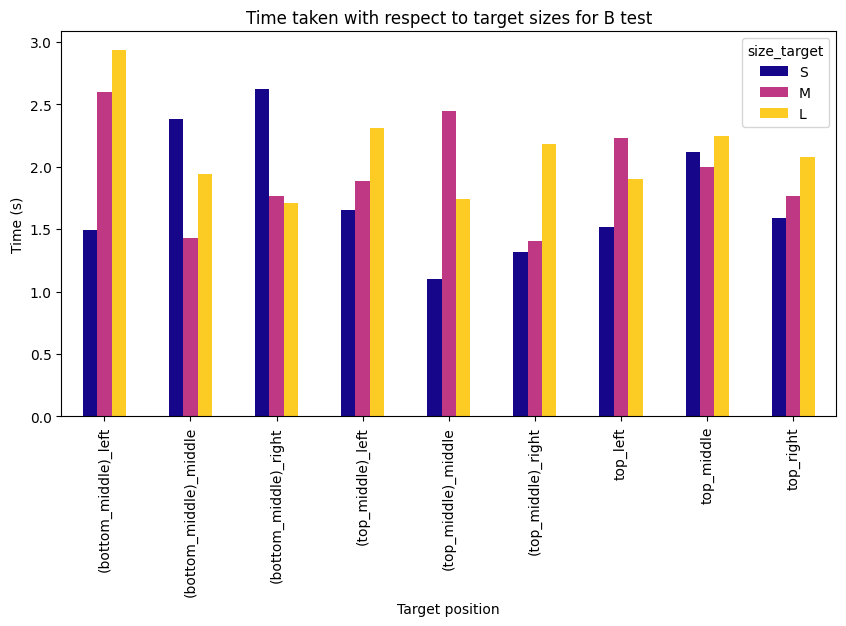

In [18]:
x = sml_hist_plotting_data.pivot_table('averages_of_time_B', ['position'], 'size_target')
x = x.reset_index(level=0)

ax = x.plot(x="position", y=["S", "M", "L"], kind="bar", rot=90, color = ['#15068a', '#be3883', '#fccc25'], title="Time taken with respect to target sizes for B test", xlabel = "Target position", ylabel = "Time (s)")


<p style="color:red">
Comparing this histogram to the above one, we directly notice that this test is faster than A test by average of 1 second. Here, they are limited to using just their finger so users were generally faster than A test.<br/>
Here, target Small bottom_middle left took on average 1.5 seconds where in A test it took more than 4 seconds which also confirms our observations. 
</p>

# 4- Histogram AB testing over 27 tests 

### This is to compare time if users were more comfortable in A or B

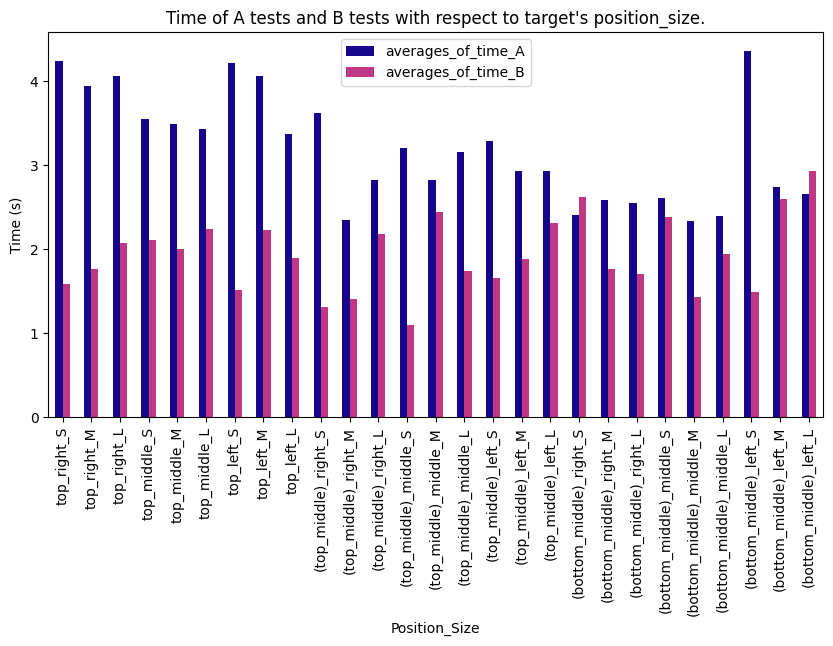

In [19]:
sml_hist_plotting_data["position_size_target"] = sml_hist_plotting_data[['position', 'size_target']].agg('_'.join, axis=1)
sml_hist_plotting_data = sml_hist_plotting_data.sort_values(by = ["position_size_target"], ascending = False)
ax = sml_hist_plotting_data.plot(x="position_size_target", y=["averages_of_time_A", "averages_of_time_B"], kind="bar", rot=90, color = ['#15068a', '#be3883'], xlabel = "Position_Size", ylabel = "Time (s)", title = "Time of A tests and B tests with respect to target's position_size.")

<p style="color: red">
We notice that tests A take more time than tests B because when users have the choice of method they take more time to reach the target since they get more confused before taking the decision. (our observation)<br/>
Some times, users tried to use one inconvenient method at first, then when they fail, they resort to the other method. Resulting in more time to hit the target.
</p>

# 5- Model Error rate

In [20]:
error_rate_df_A = dfs["A"].filter(regex= ("^error_nb_[a-zA-Z0-9]*|test_nb|size_target|position$")).sort_values(by = "test_nb")
averages_of_errors_A = pd.DataFrame(error_rate_df_A.iloc[:,1:-2].mean(axis=1))
error_rate_df_A["position_size_target"] = error_rate_df_A[['position', 'size_target']].agg('_'.join, axis=1)
averages_of_errors_A.columns = ["averages_of_errors_A"]


error_rate_df_B = dfs["B"].filter(regex= ("^error_nb_[a-zA-Z0-9]*|test_nb$")).sort_values(by = "test_nb")
averages_of_errors_B = pd.DataFrame(error_rate_df_B.iloc[:,1:].mean(axis=1))
averages_of_errors_B.columns = ["averages_of_errors_B"]


my_error_plotting_data = pd.concat((averages_of_errors_A, averages_of_errors_B, error_rate_df_A), axis = 1).filter(["test_nb", "averages_of_errors_A", "averages_of_errors_B", "position_size_target"])
my_error_plotting_data = my_error_plotting_data.sort_values(by = ["position_size_target"], ascending = False)


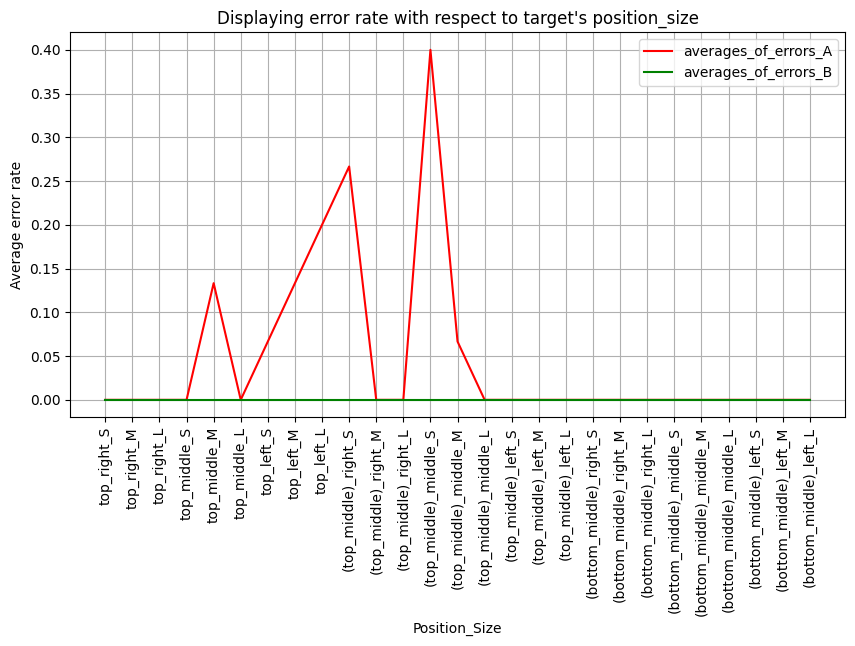

In [21]:
x_A = my_error_plotting_data.position_size_target
y_A = my_error_plotting_data.averages_of_errors_A

# plt.scatter(x, y)
plt.plot(x_A, y_A, color='r', label='averages_of_errors_A')

x_B = my_error_plotting_data.position_size_target
y_B = my_error_plotting_data.averages_of_errors_B

# plt.scatter(x, y)
plt.plot(x_B, y_B, color='g', label='averages_of_errors_B')

plt.xticks(rotation=90)

plt.grid(True)
plt.legend()
plt.title("Displaying error rate with respect to target's position_size")
plt.xlabel('Position_Size')
plt.ylabel('Average error rate');

<p style="color:red">
In general, we have a very low error rate in our tests (0.4).<br/>
    <b>B tests</b><br/>
    B tests have 0 error rate. This is explained by the fact that users have years of training with their smartphones using their fingers to reach targets regardless of the position and size.<br/>
    <b>A tests</b><br/>
    A tests also represent a small error rate. For bottom middle positions, users mainly used direct touch approach (based on the above histogram). Which explain the flat line. Now, considering that top left, middle, and right were the hardest targets, we can see that the error rate is higher than others.<br/>
    The peak of errors is top middle middle small target, we would say that is beacuse it's in the middle of the screen and the target most surrounded by noise.
</p>

# 6 - Learning Curve

In [22]:
dfs = {}

for suffix in ["A", "B"]:
    first = True
    new_csv = None
    count = 0
    df = pd.DataFrame()
    for file in dir_list:
        keep_same = {}
        x = re.search("^[a-zA-Z0-9]*_" + suffix + ".csv$", file)
        if x:
            new_csv = pd.read_csv(file)
            new_csv = new_csv.drop(columns=['W', 'D', 'Fitts', 'error_nb', 'method', 'test_nb'])
            temp_str = "_" + file.split("_")[0]
            new_csv.columns = ['{}{}'.format(c, '' if c in keep_same else temp_str ) for c in new_csv.columns]
            if first:
                df = new_csv
                first = False
            else:
                df = pd.concat((df, new_csv), axis = 1)
            count += 1
    dfs[suffix] = df

In [23]:
learning_curve_plotting_data_A = dfs["A"].mean(axis=1)
learning_curve_plotting_data_A = pd.DataFrame(learning_curve_plotting_data_A)
learning_curve_plotting_data_A.columns = ["average_time_A"]

learning_curve_plotting_data_B = dfs["B"].mean(axis=1)
learning_curve_plotting_data_B = pd.DataFrame(learning_curve_plotting_data_B)
learning_curve_plotting_data_B.columns = ["average_time_B"]

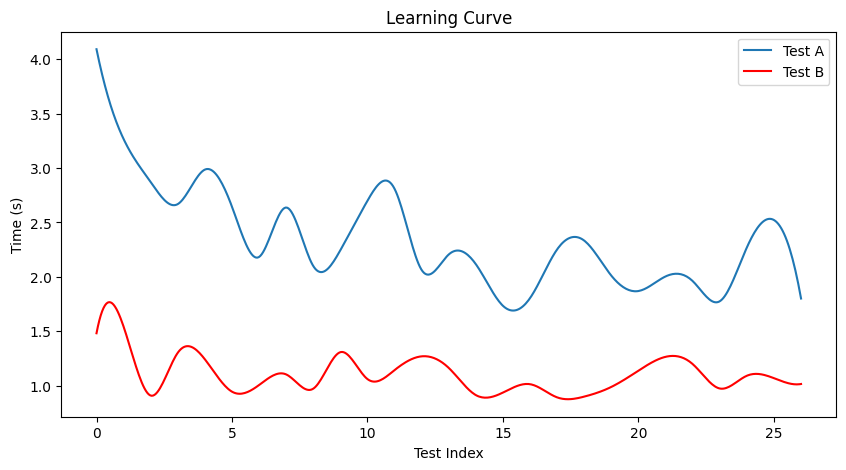

In [24]:
x_A = learning_curve_plotting_data_A.index
y_A = learning_curve_plotting_data_A.average_time_A

x_B = learning_curve_plotting_data_B.index
y_B = learning_curve_plotting_data_B.average_time_B

X_Y_Spline_A = make_interp_spline(x_A, y_A)
X_Y_Spline_B = make_interp_spline(x_B, y_B)
 
# Returns evenly spaced numbers
# over a specified interval.
Xa_ = np.linspace(x_A.min(), x_A.max(), 500)
Ya_ = X_Y_Spline_A(Xa_)

Xb_ = np.linspace(x_B.min(), x_B.max(), 500)
Yb_ = X_Y_Spline_B(Xb_)
 
# Plotting the Graph
plt.plot(Xa_, Ya_, label = "Test A")
plt.plot(Xb_, Yb_, color= 'r', label = "Test B")

plt.legend()
plt.title("Learning Curve")
plt.xlabel("Test Index")
plt.ylabel("Time (s)")
plt.show()

<p style="color:red">
In our tests, we always had the pattern of A tests followed by B tests. <br/>
For B tests, users didn't have much of a learning growth because as we mentioned before, users are already very familiar with the direct touch approach. Also, considering that users did B tests after A, this means they are now used to the interface and the goal of this experiment. The first tasks took more time than the later ones. This is because users were still used to the fact that they need to think and take a decision before reaching the target.<br/>
For A tests, we can see a nice learning curve. People were getting faster as they get deeper in the experiment. However, the small rise at the end of the curve is a result of some users getting bored and frustrated at the end of the experiment. (we will show this in the survey's results.
</p>